# Practice 9A: Decision Trees
Ref: Aurélien Géron. "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow"

### (1) Train and fine-tune a Decision Tree for the moons dataset.

#### (1.a) Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`

In [10]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

#### (1.b) Split it into a training set and a test set using `train_test_split()`.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### (1.c) Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [13]:
grid_search_cv.best_params_

{'max_leaf_nodes': 17, 'min_samples_split': 2}

#### (d) Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set.

In [14]:
from sklearn.metrics import classification_report 

y_pred = grid_search_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1013
           1       0.88      0.86      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



By default, `GridSearchCV` trains the best model found on the whole training set. 

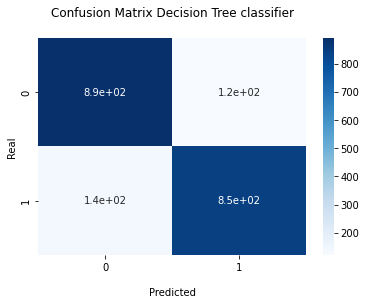

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Decision Tree classifier\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Real');

## Display the visualization of the Confusion Matrix.
plt.show()

### (2) Grow a forest.



#### (2.a) Continuing the previous exercise, generate $1, 000$ subsets of the training set, each containing $100$ instances selected randomly. Hint: you can use Scikit-Learn’s `ShuffleSplit` class for this.

In [16]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

#### (2.b) Train one DecisionTree on each subset, using the best hyperparameter values found above. Evaluate these 1, 000 Decision Trees on the test set.

In [17]:
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

Since each single tree has been trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree: the average accuracy of the single decision trees is $80\%$.

#### (2.c) For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s `mode()` function for this). This gives you majority-vote predictions over the test set.

In [18]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [19]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


#### (2.d) Evaluate these predictions on the test set. Which are the performances compared to the single model trained in point 1.

In [20]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

In [21]:
print(classification_report(y_test, y_pred_majority_votes.reshape([-1])))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1013
           1       0.87      0.87      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



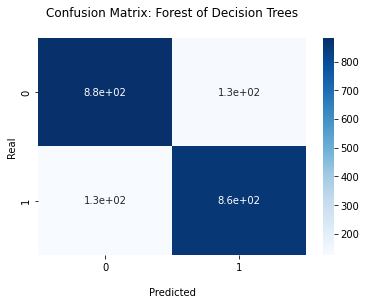

In [22]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_majority_votes.reshape([-1])), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix: Forest of Decision Trees\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Real');

## Display the visualization of the Confusion Matrix.
plt.show()

With the forest of 1000 simple Decision Trees and a prediction made by majority voting, we obtain comparable accuracy scores than our first model (single Decision Tree).

With the code above we did train a Forest of Trees. The same classifier can be trained by means of the Sklearn implementation of `RandomForestClassifier`. As you can see, the performances are the same as the ones achieved above. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=17, min_samples_split=2 , n_jobs=-1)

rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1013
           1       0.87      0.87      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



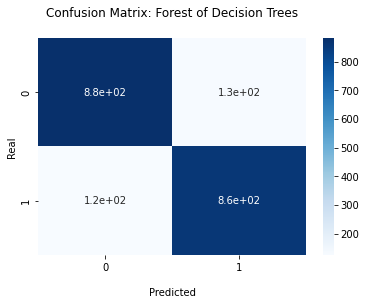

In [25]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix: Forest of Decision Trees\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Real');

## Display the visualization of the Confusion Matrix.
plt.show()